In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from sklearn.utils import shuffle
import openslide
import os
import sys
from shutil import copyfile, move
from tqdm import tqdm
import h5py
import random
from random import randint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16
from keras.losses import mean_squared_error
import keras as K
from sklearn.metrics import cohen_kappa_score

In [35]:
df = pd.read_csv("/kaggle/input/prostate-cancer-grade-assessment/train.csv")
image_path = "/kaggle/input/prostate-cancer-grade-assessment/train_images/"

In [36]:
df.shape

(10616, 4)

In [37]:
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [38]:
image_size = 256
training_sample_percentage = 0.8
training_item_count = int(len(train_df)*training_sample_percentage)
df["image_path"] = [image_path+image_id+".tiff" for image_id in df["image_id"]]

In [39]:
df.shape

(10616, 5)

In [40]:
index_to_drop = []
for idx, row in df.iterrows():
    mask_path = row.image_path.replace("train_images","train_label_masks").replace(".tiff","_mask.tiff")

    if not os.path.isfile(mask_path):
        index_to_drop.append(idx)

df.drop(index_to_drop,0,inplace=True)

/tmp/ipykernel_28/871932352.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_to_drop,0,inplace=True)


In [41]:
df.shape

(10516, 5)

In [42]:
train_df,test_df=df[:10000],df[10000:]

In [43]:
train_df.shape,test_df.shape

((10000, 5), (516, 5))

In [48]:
example = openslide.OpenSlide(train_df.iloc[].image_path)
print(example.dimensions)
clipped_example = example.read_region((5000, 5000), 0, (256, 256))
plt.imshow(clipped_example)
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4242631012.py, line 1)

In [49]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,image_path
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,/kaggle/input/prostate-cancer-grade-assessment...
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,/kaggle/input/prostate-cancer-grade-assessment...
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,/kaggle/input/prostate-cancer-grade-assessment...


In [50]:
train_df = shuffle(train_df)
validation_df = train_df[training_item_count:]
train_df = train_df[:training_item_count]

In [51]:
def get_single_sample(image_path,image_size=256,training=False,display=False):
    '''
    Return a single 256x256 sample
    with possibility of returning a gleason score using the masks
    '''
    
    image = openslide.OpenSlide(image_path)
    
    mask_path = image_path.replace("train_images","train_label_masks").replace(".tiff","_mask.tiff")
    mask = openslide.OpenSlide(mask_path)
    
    stacked_image = []
    groundtruth_per_image = []
    
    maximum_iteration = 0
    selected_sample = False
    while not selected_sample:
        sampling_start_x = randint(image_size,image.dimensions[0]-image_size)
        sampling_start_y = randint(image_size,image.dimensions[1]-image_size)

        clipped_sample = image.read_region((sampling_start_x, sampling_start_y), 0, (256, 256))
        clipped_array = np.asarray(clipped_sample)
        
        #check that the sample is not empty
        #and use the standard deviation to make sure
        #there is something happening in the sample
        if (not np.all(clipped_array==255) and np.std(clipped_array)>20) or maximum_iteration>200:
            if display:
                plt.imshow(clipped_sample)
                plt.show()
                
            sampled_image = clipped_array[:,:,:3]
            if training:
                clipped_mask = mask.read_region((sampling_start_x, sampling_start_y), 0, (256, 256))
                groundtruth_per_image.append(np.mean(np.asarray(clipped_mask)[:,:,0]))
            
            selected_sample = True
        maximum_iteration+=1
    
    if training: 
        return np.array(sampled_image), np.array(groundtruth_per_image)
    else:
        return np.array(sampled_image)

In [52]:
def get_random_samples(image_path,image_size=256,display=False):
    '''
    Load an image and select random areas.
    Return a list of 3 images from areas where there is data.
    '''
    
    image = openslide.OpenSlide(image_path)
    stacked_image = []
    
    selected_samples = 0
    maximum_iteration = 0
    while selected_samples<3:
        sampling_start_x = randint(image_size,image.dimensions[0]-image_size)
        sampling_start_y = randint(image_size,image.dimensions[1]-image_size)

        clipped_sample = image.read_region((sampling_start_x, sampling_start_y), 0, (256, 256))
        clipped_array = np.asarray(clipped_sample)
        
        #check that the sample is not empty
        #and use the standard deviation to make sure
        #there is something happening in the sample
        if (not np.all(clipped_array==255) and np.std(clipped_array)>20) or maximum_iteration>200:
            if display:
                plt.imshow(clipped_sample)
                plt.show()

            stacked_image.append(clipped_array[:,:,:3])
            selected_samples+=1
        maximum_iteration+=1
    return np.array(stacked_image)

In [53]:
get_random_samples(train_df.iloc[2].image_path).shape

(3, 256, 256, 3)

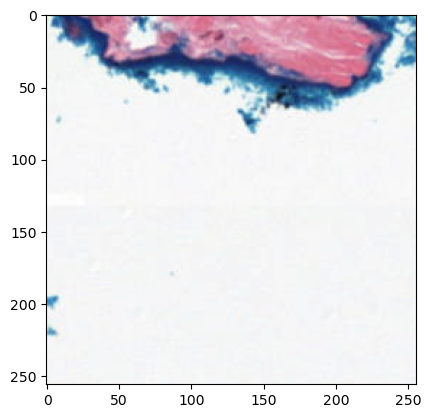

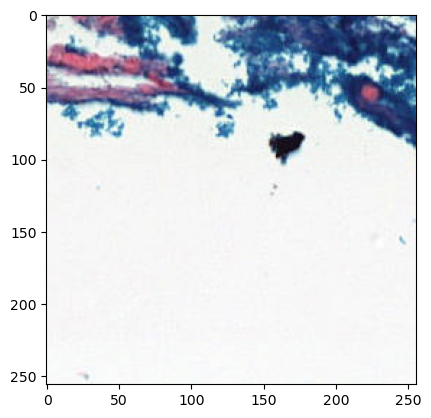

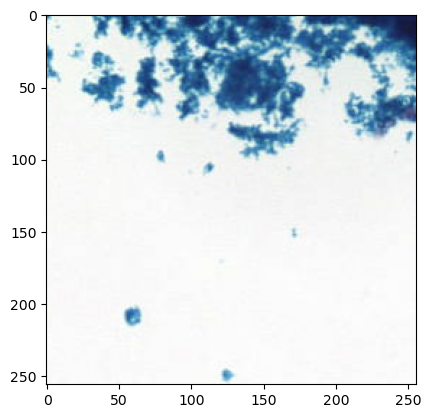

In [54]:
_ = get_random_samples(train_df.iloc[2].image_path, display=True)

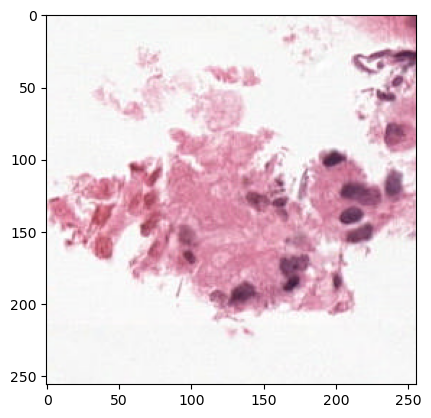

[1.50546265]


In [88]:
output = get_single_sample(test_df.iloc[0].image_path, display=True, training=True)
print(output[1])

In [56]:
def custom_single_image_generator(image_path_list, batch_size=16):
    '''
    return an image and a corresponding gleason score from the mask
    '''
    
    while True:
        for start in range(0, len(image_path_list), batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)

            image_info_list = [get_single_sample(image_path, training=True) for image_path in image_path_list[start:end]]
            X_batch = np.array([image_info[0]/255. for image_info in image_info_list])
            Y_batch = np.array([image_info[1] for image_info in image_info_list])
            
            yield X_batch, Y_batch

In [57]:
num_channel = 3
image_shape = (image_size, image_size, num_channel)

def branch(input_image):
    x = Conv2D(128, (3, 3))(input_image)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    x = layers.Dense(256)(x)
    x = Activation('relu')(x)
    
    return layers.Dropout(0.3)(x)

In [58]:
input_image = Input(shape=image_shape)
core_branch = branch(input_image)
output = Dense(1, activation='linear')(core_branch)

branch_model = Model(input_image,output)

In [63]:
branch_model.compile(loss="mse",
                      optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_branch.h5', monitor='val_loss', save_best_only=True)]

batch_size = 16

history = branch_model.fit(custom_single_image_generator(train_df["image_path"], batch_size=batch_size),
                        steps_per_epoch = int(len(train_df)/(16*batch_size)),
                        validation_data=custom_single_image_generator(validation_df["image_path"], batch_size=batch_size),
                        validation_steps= int(len(validation_df)/(batch_size*16)),
                        epochs=1,
                        callbacks=callbacks)

29/29 [==============================] - 141s 5s/step - loss: 0.4687 - val_loss: 0.6573 - lr: 0.0010


In [ ]:
ans = branch_model.predict(custom_single_image_generator(test_df["image_path"][:1],batch_size=16))

In [74]:
def custom_generator(image_path_list, groundtruth_list, batch_size=16):
    num_classes=6
    while True:
        for start in range(0, len(image_path_list), batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)
            
            X_batch = np.array([get_random_samples(image_path)/255. for image_path in image_path_list[start:end]])
            input_image1 = X_batch[:,0,:,:]
            input_image2 = X_batch[:,1,:,:]
            input_image3 = X_batch[:,2,:,:]
            
            Y_batch = tf.keras.utils.to_categorical(np.array(groundtruth_list[start:end]),num_classes) 
            
            yield [input_image1,input_image2,input_image3], Y_batch

In [75]:
def input_branch(input_image):
    '''
    Generate a new input branch using our previous weights
    
    '''
    input_image = Input(shape=image_shape)
    core_branch = branch(input_image)
    output = Dense(1, activation='linear')(core_branch)
    branch_model = Model(input_image,output)
    branch_model.load_weights("../working/best_branch.h5")
        
    new_branch = Model(inputs=branch_model.input, outputs=branch_model.layers[-2].output)
    
    for layer in new_branch.layers[:-3]:
        layer.trainable = False
    
    return new_branch

In [26]:
test_dat = "./input/prostate-cancer-grade-assessment/test.csv"

In [27]:
test_dat

'./input/prostate-cancer-grade-assessment/test.csv'